In [1]:
import warnings
warnings.filterwarnings('ignore')

from glob import glob
import pandas as pd
import numpy as np 
from tqdm import tqdm
import cv2
import PIL

import os
import timm
import random
import shutil
import copy

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
import time

import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models
import matplotlib.pyplot as plt

device = torch.device('cuda')

In [2]:
# Code for Reproduction

def seed_everything(seed: int = 20220511):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  

In [38]:
# Input your own directory

file_dir = 'D:/thon/DL/zindi'
img_dir = file_dir + '/Images'

train_df = pd.read_csv(file_dir + "/Train.csv")
test_df = pd.read_csv(file_dir + '/Test.csv')
train_labels = train_df["Label"]

label_unique = sorted(np.unique(train_labels))
label_unique = {key:value for key, value in zip(label_unique, range(len(label_unique)))}

train_labels = [label_unique[k] for k in train_labels]

In [39]:
train_dir = img_dir + '/train'
test_dir = img_dir + '/test'

train_jpg = sorted(glob(train_dir + '/*.jpg'))
test_jpg = sorted(glob(test_dir + '/*.jpg'))

In [40]:
img_size = 224 # input size for efficientnet_b0 : 224 * 224

def img_load(path):
    img = cv2.imread(path)[:,:,::-1]
    img = cv2.resize(img, (img_size, img_size))
    return img

In [41]:
# Load images

train_imgs = [img_load(m) for m in tqdm(train_jpg)]
test_imgs = [img_load(n) for n in tqdm(test_jpg)]

100%|██████████| 1080/1080 [00:19<00:00, 56.49it/s]


In [42]:
# Data Augmentation for train, pass it for test

class Custom_dataset(Dataset):
    def __init__(self, img_paths, labels, mode = 'train'):
        self.img_paths = img_paths
        self.labels = labels
        self.mode = mode

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = self.img_paths[idx]

        if self.mode == 'train':
            augmentation = random.randint(0,2) # augmentation

            if augmentation == 1:
                img = img[::-1].copy()

            elif augmentation == 2:
                img = img[:,::-1].copy()
                
        img = transforms.ToTensor()(img)

        if self.mode == 'test': # no augmentation for test images
            pass
        
        label = self.labels[idx]
        return img, label

In [59]:
# custom train and test images

batch_size = 32
epochs = 25

# Train

train_dataset = Custom_dataset(np.array(train_imgs), np.array(train_labels), mode = 'train')
train_loader = DataLoader(train_dataset, shuffle = True, batch_size = batch_size)

# Test

test_dataset = Custom_dataset(np.array(test_imgs), np.array(["tmp"] * len(test_imgs)), mode = 'test')
test_loader = DataLoader(test_dataset, shuffle = False, batch_size = batch_size)

In [35]:
# 학습을 위해 데이터 증가(augmentation) 및 일반화(normalization)
# 검증을 위한 일반화
## 안씀

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.444, 0.535, 0.336], [0.169, 0.166, 0.172])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.444, 0.535, 0.336], [0.169, 0.166, 0.172])
    ]),
}

data_dir = 'D:/thon/DL/zindi/Images_ResNEt'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
                  
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = 4,
                                             shuffle = True, num_workers = 4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

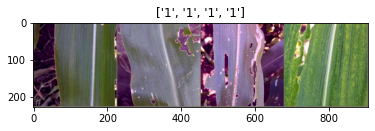

In [15]:
# 일부 이미지 시각화

def imshow(inp, title = None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title = [class_names[x] for x in classes])

### 모델 학습 함수 및 예측값 시각화 함수 (안 씀)

In [16]:
# 모델 학습 함수 정의

def train_model(model, criterion, optimizer, scheduler, num_epochs = 25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data) # AUC를 쓰려면 이 부분을 고쳐야할듯
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [17]:
# 모델 예측값 시각화 함수 정의

def visualize_model(model, num_images = 6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode = was_training)
                    return
        model.train(mode = was_training)

# ResNet18로 학습

In [46]:
def score_function(real, pred):
    score = roc_auc_score(real, pred, average = "macro")
    return score


resnet18 = models.resnet18(pretrained = True)
num_ftrs = resnet18.fc.in_features

# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.

resnet18.fc = nn.Linear(num_ftrs, 2)

resnet18 = resnet18.to(device)

criterion = nn.CrossEntropyLoss()


# 모든 매개변수들이 최적화되었는지 관찰

resnet18_optimizer_ft = optim.Adam(resnet18.parameters(), lr = 0.001)


# 7 에폭마다 0.1씩 학습률 감소

exp_lr_scheduler = lr_scheduler.StepLR(resnet18_optimizer_ft, step_size = 7, gamma = 0.1)

scaler = torch.cuda.amp.GradScaler() 



best = 0

for epoch in range(epochs):
    start = time.time()
    train_loss = 0
    train_pred = []
    train_y = []
    resnet18.train()
    for batch in (train_loader):
        resnet18_optimizer_ft.zero_grad()
        x = torch.tensor(batch[0], dtype = torch.float32, device = device)
        y = torch.tensor(batch[1], dtype = torch.long, device = device)
        with torch.cuda.amp.autocast():
            pred = resnet18(x)
        loss = criterion(pred, y)


        scaler.scale(loss).backward()
        scaler.step(resnet18_optimizer_ft)
        scaler.update()
        
        train_loss += loss.item()/len(train_loader)
        train_pred += pred.argmax(1).detach().cpu().numpy().tolist()
        train_y += y.detach().cpu().numpy().tolist()
        
    
    train_auc = score_function(train_y, train_pred)

    TIME = time.time() - start
    print(f'epoch : {epoch+1}/{epochs}    time : {TIME:.0f}s/{TIME*(epochs-epoch-1):.0f}s')
    print(f'TRAIN    loss : {train_loss:.5f}    AUC : {train_auc:.5f}')

epoch : 1/25    time : 7s/180s
TRAIN    loss : 0.16762    AUC : 0.93328
epoch : 2/25    time : 7s/169s
TRAIN    loss : 0.08100    AUC : 0.96973
epoch : 3/25    time : 7s/161s
TRAIN    loss : 0.08503    AUC : 0.96541
epoch : 4/25    time : 7s/154s
TRAIN    loss : 0.02715    AUC : 0.99012
epoch : 5/25    time : 7s/143s
TRAIN    loss : 0.02165    AUC : 0.99259
epoch : 6/25    time : 7s/140s
TRAIN    loss : 0.02661    AUC : 0.99197
epoch : 7/25    time : 7s/133s
TRAIN    loss : 0.04487    AUC : 0.98147
epoch : 8/25    time : 7s/124s
TRAIN    loss : 0.06798    AUC : 0.97714
epoch : 9/25    time : 7s/117s
TRAIN    loss : 0.01543    AUC : 0.99382
epoch : 10/25    time : 7s/110s
TRAIN    loss : 0.01515    AUC : 0.99382
epoch : 11/25    time : 7s/104s
TRAIN    loss : 0.01764    AUC : 0.99321
epoch : 12/25    time : 7s/97s
TRAIN    loss : 0.01564    AUC : 0.99444
epoch : 13/25    time : 7s/89s
TRAIN    loss : 0.00998    AUC : 0.99691
epoch : 14/25    time : 7s/81s
TRAIN    loss : 0.00539    AUC 

In [53]:
resnet18.eval()
f_pred = []

with torch.no_grad():
    for batch in (test_loader):
        x = torch.tensor(batch[0], dtype = torch.float32, device = device)
        with torch.cuda.amp.autocast():
            pred = resnet18(x)
        f_pred.extend(pred.argmax(1).detach().cpu().numpy().tolist())

In [54]:
label_decoder = {val:key for key, val in label_unique.items()}

f_result = [label_decoder[result] for result in f_pred]

In [55]:
submission = pd.read_csv("./zindi/SampleSubmission.csv")
submission["Label"] = f_result
submission

,Image_id,Label
0,id_00exusbkgzw1b.jpg,0
1,id_03dqinf6w0znv.jpg,0
2,id_046yl0cxn3ybz.jpg,1
3,id_04athdtx2abyg.jpg,0
4,id_062aauf9e9jk0.jpg,0
...,...,...
1075,id_zv5fvjnakvf1r.jpg,1
1076,id_zvpikh1z30arn.jpg,0
1077,id_zypilwkudljyz.jpg,0
1078,id_zz9lwehh5sxdp.jpg,1


In [57]:
perfect = pd.read_csv('./zindi/submission_csv/Perfect_AUC.csv')

print(np.sum(submission["Label"] == perfect['Label']), len(submission["Label"]))

1074 1080


In [56]:
submission.to_csv('./zindi/submission_csv/resnet18.csv', index = False)

# EfficientNetb0로 학습

In [62]:
def score_function(real, pred):
    score = roc_auc_score(real, pred, average = "macro")
    return score


effnetb0 = models.efficientnet_b0(pretrained = True)
effnetb0 = effnetb0.to(device)

effnet_optimizer = torch.optim.Adam(effnetb0.parameters(), lr = 1e-3)
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler() 


best = 0

for epoch in range(epochs):
    start = time.time()
    train_loss = 0
    train_pred = []
    train_y = []
    effnetb0.train()
    for batch in (train_loader):
        effnet_optimizer.zero_grad()
        x = torch.tensor(batch[0], dtype = torch.float32, device = device)
        y = torch.tensor(batch[1], dtype = torch.long, device = device)
        with torch.cuda.amp.autocast():
            pred = effnetb0(x)
        loss = criterion(pred, y)


        scaler.scale(loss).backward()
        scaler.step(effnet_optimizer)
        scaler.update()
        
        train_loss += loss.item()/len(train_loader)
        train_pred += pred.argmax(1).detach().cpu().numpy().tolist()
        train_y += y.detach().cpu().numpy().tolist()
        
    
    train_auc = score_function(train_y, train_pred)

    TIME = time.time() - start
    print(f'epoch : {epoch+1}/{epochs}    time : {TIME:.0f}s/{TIME*(epochs-epoch-1):.0f}s')
    print(f'TRAIN    loss : {train_loss:.5f}    AUC : {train_auc:.5f}')

epoch : 1/25    time : 48s/1147s
TRAIN    loss : 0.77598    AUC : 0.87176
epoch : 2/25    time : 47s/1084s
TRAIN    loss : 0.07158    AUC : 0.98024
epoch : 3/25    time : 48s/1052s
TRAIN    loss : 0.02243    AUC : 0.99073
epoch : 4/25    time : 45s/941s
TRAIN    loss : 0.02943    AUC : 0.98888
epoch : 5/25    time : 49s/983s
TRAIN    loss : 0.02639    AUC : 0.99135
epoch : 6/25    time : 49s/934s
TRAIN    loss : 0.00957    AUC : 0.99629
epoch : 7/25    time : 49s/880s
TRAIN    loss : 0.01993    AUC : 0.99382
epoch : 8/25    time : 49s/832s
TRAIN    loss : 0.04798    AUC : 0.98332
epoch : 9/25    time : 49s/781s
TRAIN    loss : 0.04566    AUC : 0.98765
epoch : 10/25    time : 49s/732s
TRAIN    loss : 0.01675    AUC : 0.99382
epoch : 11/25    time : 49s/683s
TRAIN    loss : 0.01864    AUC : 0.99382
epoch : 12/25    time : 49s/635s
TRAIN    loss : 0.02510    AUC : 0.99074
epoch : 13/25    time : 47s/570s
TRAIN    loss : 0.01205    AUC : 0.99629
epoch : 14/25    time : 48s/533s
TRAIN    lo

In [63]:
effnetb0.eval()
effnetb0_f_pred = []

with torch.no_grad():
    for batch in (test_loader):
        x = torch.tensor(batch[0], dtype = torch.float32, device = device)
        with torch.cuda.amp.autocast():
            pred = effnetb0(x)
        effnetb0_f_pred.extend(pred.argmax(1).detach().cpu().numpy().tolist())

In [64]:
label_decoder = {val:key for key, val in label_unique.items()}

effnetb0_f_result = [label_decoder[result] for result in effnetb0_f_pred]

In [65]:
effnetb0_sub = pd.read_csv("./zindi/SampleSubmission.csv")
effnetb0_sub["Label"] = effnetb0_f_result

In [66]:
perfect = pd.read_csv('./zindi/submission_csv/Perfect_AUC.csv')

print(np.sum(effnetb0_sub["Label"] == perfect['Label']), len(effnetb0_sub["Label"]))

1078 1080


In [67]:
effnetb0_sub.to_csv('./zindi/submission_csv/effnetb0_0511.csv', index = False)